In [2]:
import numpy as np
import tensorflow as tf
import utils
from tictactoegame import TicTacToe as Board
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [508]:
class RLNN():
    def __init__(self, alpha, gamma):
        self.vhat = tf.keras.Sequential()
        self.vhat.add(tf.keras.layers.Dense(18,activation='relu'))
        self.vhat.add(tf.keras.layers.Dense(18,activation='tanh'))
        self.vhat.add(tf.keras.layers.Dense(18))
        self.vhat.add(tf.keras.layers.Flatten())
        self.vhat.add(tf.keras.layers.Dense(1))
        
        self.alpha = alpha
        self.gamma = gamma
        self.policy = tf.keras.Sequential()
        expansion = tf.keras.layers.Dense(64, activation='tanh')
        dense0 = tf.keras.layers.Dense(32, activation='tanh')
        dense1 = tf.keras.layers.Dense(18)#, activation='tanh')
        dense2 = tf.keras.layers.Dense(9, activation='sigmoid')
        dense3 = tf.keras.layers.Dense(9)#, activation='sigmoid')
#         flatten = tf.keras.layers.Flatten()
        output = tf.keras.layers.Dense(9, activation='softmax')
#         self.policy.add(expansion)
#         self.policy.add(dense0)
        self.policy.add(dense1)
#         self.policy.add(dense2)
        self.policy.add(dense3)
#         self.policy.add(flatten)
        self.policy.add(output)


# ------------------------------------------------------------------ #    
# Returns the gradient-log-probabilities multiplied by the reward-to-go, summed over each state-action pair.
    def get_pg(self, episode, reward_fn):
        A,S = zip(*episode[:-1])
        A = list(A)
        S = list(S) + [episode[-1]]
        R = [reward_fn(i) for i in S]
        rtgs = np.zeros_like(R)
        T = len(A)-1
        for i in reversed(range(len(R))):
            rtgs[i] = R[i] + (rtgs[i+1] if i+1 < len(R) else 0)
#         grad_sum = [np.zeros_like(i.numpy()) for i in self.policy.trainable_variables]
        grad_sum = []
        t = T
        for st, at, rt in zip(S[:-1],A,rtgs[:-1]): #<-- changed from rtgs[:-1] to rtgs[1:] (this makes more sense)
            st = utils.board_to_features(st)    # <--- convert board to 'feature vectors'
            at = 3*at[0] + at[1]
            with tf.GradientTape(persistent=True) as tape:
                probs = tf.squeeze(self.policy(st.T))
                logp = tf.math.log(probs[at]) + np.full((9),0.000001)
                l2_norms = [tf.norm(w) for w in self.policy.variables]
                
            grads = tape.gradient(logp, self.policy.variables)
            grad_norms = tape.gradient(l2_norms,self.policy.variables)
            grads[0] -= grad_norms[0] # <-- lambda = 2
            grads[2] -= grad_norms[2]
            
            if len(grad_sum) == 0:
                grad_sum = [(self.gamma**t)*rt*g for g in grads] # <-- now lets fix the gamma and see difference
            else:
                for i in range(len(grads)):
                    grad_sum[i] += (self.gamma**t)*rt*grads[i]
            t-=1
#         grad_sum = [i / T for i in grad_sum]
        return grad_sum
        
    def train2(self, epochs, batch_size, reward_fn):
        board=Board()
        illegals=[]
        losses=[]
        wins=[]
        draws=[]
        n = 1
        while n <= epochs:
            grad_count=0
            illegal=0
            win=0
            lose=0
            draw=0
            print(n)
            clear_output(wait=True)
#             g_hat = [np.zeros_like(i.numpy()) for i in self.policy.trainable_variables]
            g_hat = []
            batch = [utils.gen_episode(self.policy) for i in range(batch_size)]
            # ^^ might want to record episode stats using batch episodes instead of generating new ones every time
            for episode in batch:
                grad_count+= len(episode)-1
                grads = self.get_pg(episode, reward_fn)
                if len(g_hat) == 0:
                    g_hat = grads
                else:
                    for i in range(len(grads)):   # <-- for computing expected policy gradient
                        g_hat[i] += grads[i]
                
                board.board = episode[-1]
                if 9 in episode[-1]:
                    illegal+=1
                elif board.isGameOver(-1):
                    lose+=1
                elif board.isGameOver(1):
                    win+=1
                else:
                    draw+=1
            
            g_hat = [i / grad_count for i in g_hat] # <-- grad_count used to be "batch_size"
            for grad, var in zip(g_hat, self.policy.variables):
                var.assign_add(self.alpha*grad)
            n+=1
            illegals.append(illegal/batch_size)
            losses.append(lose/batch_size)
            wins.append(win/batch_size)
            draws.append(draw/batch_size)
        return illegals,losses,wins,draws
            
    def Vhat_update(self, S, R):
        mse = tf.keras.losses.MeanSquaredError()
        for (st, rt) in zip(S,R):
            with tf.GradientTape() as tape:
                loss = mse(self.vhat(st),rt)
        return #stub
    

In [509]:
def reward_fn(state):
    board = Board()
    board.board = state
    if board.isGameOver(1):
        return 1
    if board.isGameOver(-1):
        return -1 #<-- (changed back)WTF? ACCIDENTALLY SET POSITIVE, AND ITS ACTUALLY MAKING IT EVEN BETTER?
    if 9 in board.board:
        return -1
    return 0

In [534]:
model = RLNN(10**-3, 0.7)
# test performance on a simpler, "non-sequential" RL task (e.g., picking only spots without a 1, or something)
# test how performance changes with "baseline"


In [535]:
illegal = []
lose = []
win = []
draw = []

ave_return = []

In [538]:
IR,LR,WR,DR = model.train2(2000, 20, reward_fn)
illegal+=IR
lose +=LR
win += WR
draw += DR

# Approx 20s per 100 epochs of 10 batches (20s per 1000 episodes)

500


[Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'outcome freq moving averages')]

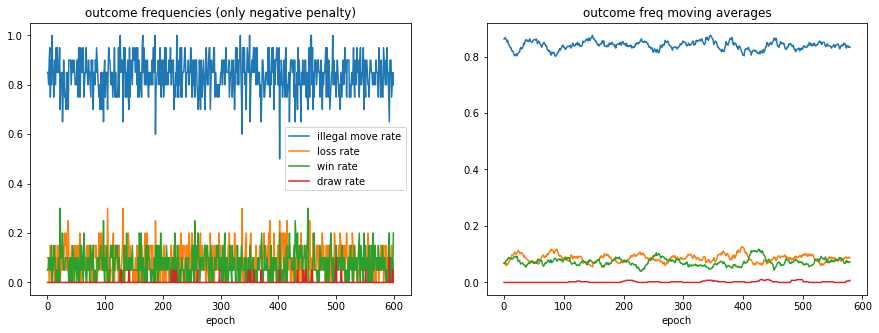

In [539]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(illegal, label='illegal move rate')
ax[0].plot(lose, label='loss rate')
ax[0].plot(win, label='win rate')
ax[0].plot(draw,label='draw rate')
ax[0].set(xlabel='epoch', title='outcome frequencies (only negative penalty)')
ax[0].legend()

ax[1].plot(moving_average(illegal, 20,1))
ax[1].plot(moving_average(lose, 20,1))
ax[1].plot(moving_average(win, 20,1))
ax[1].plot(moving_average(draw, 20,1))
ax[1].set(xlabel='epoch', title='outcome freq moving averages')

# ax[1,0].plot(illegal[1000:], label='illegal move rate')
# ax[1,0].plot(lose[1000:], label='loss rate')
# ax[1,0].plot(win[1000:], label='win rate')
# ax[1,0].plot(draw[1000:],label='draw rate')
# ax[1,0].set(xlabel='epoch')
# ax[1,0].legend()

# ax[1,1].plot(moving_average(ave_return,20,2))
# ax[1,1].plot(ave_return)
# ax[1,1].set(xlabel='epoch', title='expected returns moving ave')

# ^^^add code to record and plot returns as well

In [436]:
model.policy.save_weights('./checkpoints/0_illegal_2500epoch')

In [522]:
utils.state_dist(model.policy,1000)

(0.157, 0.013, 0.83, 0.0)

In [540]:
utils.gen_episode(model.policy)

[((0, 1),
  array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]])),
 ((1, 0),
  array([[-1,  1,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]])),
 ((1, 1),
  array([[-1,  1, -1],
         [ 1,  0,  0],
         [ 0,  0,  0]])),
 ((1, 0),
  array([[-1,  1, -1],
         [ 1,  1, -1],
         [ 0,  0,  0]])),
 array([[-1,  1, -1],
        [ 9,  1, -1],
        [ 0,  0,  0]])]

In [ ]:
def moving_average(x,size,mult):
    x_prime=[]
    while mult > 0:
        x_smooth=[]
        for i in range(len(x)-size if len(x_prime)==0 else len(x_prime)-size):
            x_smooth.append(np.mean(x[i:i+size] if len(x_prime)==0 else x_prime[i:i+size]))
        x_prime=x_smooth
        mult-=1
    return x_prime

print(moving_average(list(range(10)), 2, 3))

### TEST TASK: "select the index element with the value '1'"
This is a trivially simple *supervised* task; the output is simply the input value.
We are going to test out how well it does when we treat the problem as an *RL* task.

#### key difference: this task is not sequential, therefore the models parameters do not affect the state distribution
or does it...? the same abrupt "crashes" are still present! 

I suppose even though its non-sequential, the model can still get "stuck" if it learns the wrong things to a point where it is no longer capable of making right decisions (therefore never receiving positive reinforcement).

*the accumulation of learning "wrong behaviour" probably happens when a specific state is repeatedly missing from each batch?*

In [619]:
test_model = tf.keras.Sequential()
dense0 = tf.keras.layers.Dense(18)
dense1 = tf.keras.layers.Dense(9,activation='relu')
dense2 = tf.keras.layers.Dense(9)
output = tf.keras.layers.Dense(9,activation='softmax')
# test_model.add(dense0)
test_model.add(dense2)
test_model.add(dense1)
# test_model.add(output)

In [620]:
def test_rew(yi,xi):
    if yi == xi: return -1
    return 1

def test_train(lr, batch_size, epochs):
    ave_ret = []
    n = 1
    while n <= epochs:
        print(n)
        clear_output(wait=True)
        grads_sum = []
        Y = np.random.choice(9, size=batch_size) # <-- now lets see how it does with random sampling
#         Y = list(range(9))
        R = []
        for yi in Y:
            xi = tf.expand_dims(tf.one_hot(yi, depth=9),axis=0)
            with tf.GradientTape(persistent=True) as tape:
                probs = tf.squeeze(test_model(xi))
#                 sparse_logits = tf.sparse.from_dense(test_model(xi))
#                 probs = tf.sparse.softmax(sparse_logits)
#                 probs = tf.squeeze(tf.sparse.to_dense(probs))
        
                yhat = np.random.choice(9, p = probs.numpy()/np.sum(probs))
                logp = tf.math.log(probs[yhat]) + np.full((9),0.000001)
                l2_norms = [tf.math.reduce_sum(tf.square(w)) for w in test_model.variables]
#                 print(logp)
            grads = tape.gradient(logp, test_model.variables)
            l2_grads = tape.gradient(l2_norms, test_model.variables)
            grads = [grads[i] - l2_grads[i] for i in range(len(grads))]
            if len(grads_sum) == 0:
                grads_sum += test_rew(yi,yhat)*grads
            else:
                for i in range(len(grads)):
                    grads_sum[i] += test_rew(yi,yhat)*grads[i]
            R.append(test_rew(yi,yhat))
#         print(grads_sum)
        for i in range(len(grads_sum)):
            grads_sum[i] /= batch_size # /= 9 
        for g, var in zip(grads_sum,test_model.variables):
            var.assign_add(lr*g)
        ave_ret.append(np.mean(R))
        n+=1
    return ave_ret



In [621]:
returns = []

In [624]:
ret = test_train(10**-2,10,200)
returns = returns + ret

200


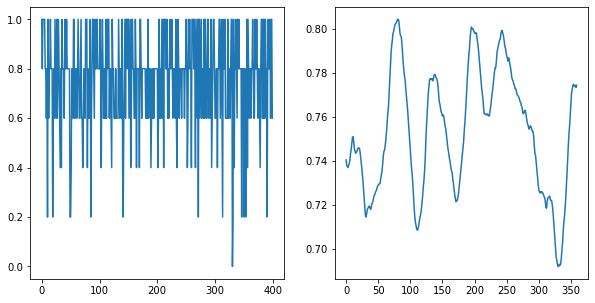

In [625]:
# plt.plot(returns)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(returns)
ax[1].plot(moving_average(returns,20,2))

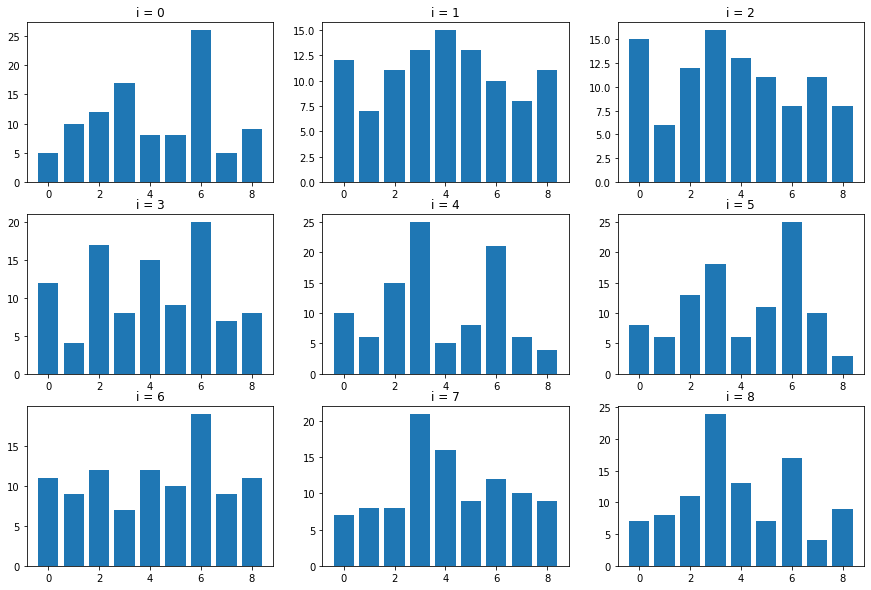

In [589]:
X_test = tf.one_hot(list(range(9)),depth=9)
x_probs = test_model(X_test)
probs = []
xhat = [np.zeros_like(9) for i in range(9)]
for i in x_probs:
    probs.append(i.numpy() / np.sum(i))
for i in range(9):
    p = probs[i]
    x = xhat[i]
    for j in range(100):
        xhat[i] += tf.one_hot(np.random.choice(9,p=p),depth=9)
    
fig, ax = plt.subplots(3,3, figsize=(15,10))
for i in range(3):
    for j in range(3):
        index = 3*i + j
        ax[i,j].bar(list(range(9)),xhat[index])
        ax[i,j].set(title=f'i = {index}')

##### Demonstration of supervised learning(GD) approach to the same task, instead of RL

In [1556]:
M = tf.keras.Sequential()
d1 = tf.keras.layers.Dense(9,activation='relu')
d2= tf.keras.layers.Dense(9)
out = tf.keras.layers.Dense(9,activation='relu')
# M.add(d1)
M.add(d2)
# M.add(out)

In [1557]:
mse = tf.keras.losses.MeanSquaredError()
accu= tf.keras.metrics.Accuracy()
X = tf.one_hot(list(range(9)),depth=9)

def train(lr, epochs):
    acc=[]
    losses=[]
    n=1
    while n<=epochs:
        print(n)
        clear_output(wait=True)
        with tf.GradientTape() as tape:
            yhat = M(X)
            loss = mse(X,yhat)
#             loss = 
        grads = tape.gradient(loss,M.variables)
        for g,v in zip(grads,M.variables):
            v.assign_sub(g)
        losses.append(loss)
        n+=1
    return losses,accu

Text(0.5, 1.0, 'Supervised, GD - Loss')

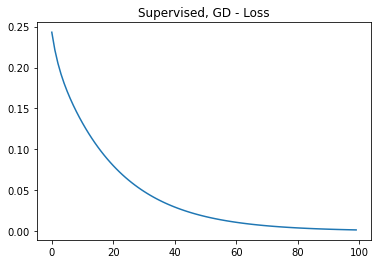

In [1558]:
loss,accu = train(0.001,100)
plt.plot(loss)
plt.title('Supervised, GD - Loss')

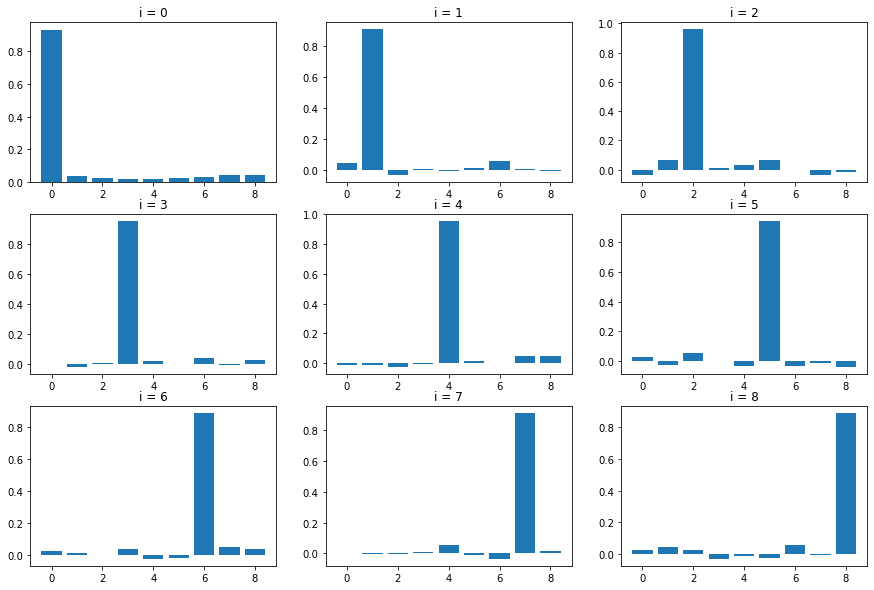

In [1559]:
fig,ax = plt.subplots(3,3,figsize=(15,10))
for i in range(3):
    for j in range(3):
        ax[i,j].bar(list(range(9)),tf.squeeze(M(tf.expand_dims(X[3*i+j],axis=0))))
        ax[i,j].set(title=f'i = {3*i+j}')

## TEST TASK: simplified sequential RL task, "Get three in a row"

In [503]:
test_model = tf.keras.Sequential()
# dense0 = tf.keras.layers.Dense(32)
dense1 = tf.keras.layers.Dense(18)
dense2 = tf.keras.layers.Dense(9)
output = tf.keras.layers.Dense(9,activation='softmax')
test_model.add(dense1)
test_model.add(dense2)
test_model.add(output)

In [786]:
def test_rew(st):
    n = 0
    for i in st:
        if i == 1:
            if n == 2:
                return 1
            n+=1
            continue
        n=0
    return 0

def test_run(s0):
    prev_s = s0
    S=[prev_s]
    A=[]
    R=0
    while True:
        probs = tf.squeeze(test_model(tf.expand_dims(prev_s,axis=0)))
        yhat = np.random.choice(9,p=probs.numpy()/np.sum(probs))
        A.append(yhat)
        if yhat in prev_s.nonzero()[0]:
            R = -1
            S.append(prev_s)
            break
        yhat = tf.one_hot(yhat,depth=9)
        next_s = np.maximum(prev_s, yhat)
        S.append(next_s.copy())
        prev_s = next_s
        if test_rew(prev_s) == 1:
            R = 1
            break
    return S,A,R
        
def test_train(lr, batch_size, epochs):
    win_rates=[]
    loss_rates=[]
    ave_ret = []
    n = 1
    while n <= epochs:
        print(n)
        clear_output(wait=True)
        grads_sum = []
        wins=0
        losses=0
        total_grads=0
        Y = np.random.choice(9, size=batch_size) 
        S0 = tf.one_hot(Y, depth=9)
        episodes = [test_run(i.numpy()) for i in S0]
        R = []
        for tau in episodes:
            for st,at in zip(tau[0][:-1], tau[1]):
                with tf.GradientTape() as tape:
                    probs = tf.squeeze(test_model(tf.expand_dims(st,axis=0)))
                    logp = tf.math.log(probs[at]) + np.full((9),0.000001)
    #                 print(logp)
                grads = tape.gradient(logp, test_model.variables)
                if len(grads_sum) == 0:
                    grads_sum += tau[2]*grads
                else:
                    for i in range(len(grads)):
                        grads_sum[i] += tau[2]*grads[i]
                R.append(tau[2])
                total_grads+=1
    #         print(grads_sum)
            if tau[2] > 0: wins+=1 
            else: losses+=1
        for i in range(len(grads_sum)):
            grads_sum[i] /= total_grads
        for g, var in zip(grads_sum,test_model.variables):
            var.assign_add(lr*g)
        ave_ret.append(np.mean(R))
        win_rates.append(wins / batch_size)
        loss_rates.append(losses / batch_size)
        n+=1
    return ave_ret, win_rates, loss_rates

In [787]:
returns = []
WR = []
LR = []

In [853]:
ret,win,lose = test_train(10**-2,10,100)
returns = returns + ret
WR = WR + win
LR = LR + lose

100


[Text(0.5, 1.0, 'loss rate')]

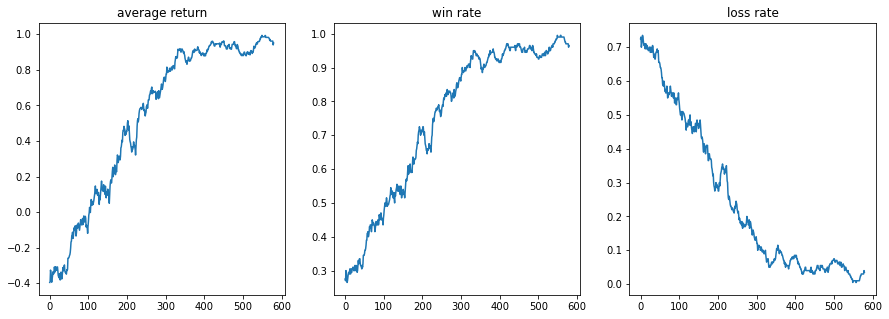

In [854]:
# plt.plot(returns)
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(moving_average(returns,20,1))
ax[0].set(title='average return')
ax[1].plot(moving_average(WR,20,1))
ax[1].set(title='win rate')
ax[2].plot(moving_average(LR,20,1))
ax[2].set(title='loss rate')

#### Reworking above train function for the tictactoe task

In [504]:
def test_train(lr, batch_size, epochs):
    win_rates=[]
    loss_rates=[]
    ave_ret = []
    n = 1
    gamma=0.7
    while n <= epochs:
        print(n)
        clear_output(wait=True)
        grads_sum = []
        wins=0
        losses=0
        total_grads=0
        episodes = [utils.gen_episode(test_model) for i in range(batch_size)]
        R = []
        for tau in episodes:
            rt = reward_fn(tau[-1])
            t = len(tau[:-1])
            for at,st in tau[:-1]:
                st = utils.board_to_features(st)
                at = 3*at[0] + at[1]
                with tf.GradientTape(persistent=True) as tape:
                    probs = tf.squeeze(test_model(st.T))
                    logp = tf.math.log(probs[at]) + np.full((9),0.000001)
                    
                    l2_norms = [tf.norm(w) for w in test_model.variables] # <-- regularization
                grads = tape.gradient(logp, test_model.variables)
                grad_norms = tape.gradient(l2_norms,test_model.variables)
                grads[0] -= grad_norms[0] # <-- lambda = 2
                grads[2] -= grad_norms[2]
                if len(grads_sum) == 0:
                    grads_sum = [(gamma**t)*rt*g for g in grads] # <-- why was rt*grads working, when grads is a list? and i forgot gamma here???
                else:
                    for i in range(len(grads)):
                        grads_sum[i] += (gamma**t)*rt*grads[i] #- grad_norms[i])# rt*grads[i]
#                         print(grads_sum[i])
                R.append(rt)
                total_grads+=1
                t-=1
    #         print(grads_sum)
            if rt > 0: wins+=1 
            else: losses+=1
        for i in range(len(grads_sum)):
            grads_sum[i] /= total_grads       
        for g, var in zip(grads_sum,test_model.variables):
            var.assign_add(lr*g)
        ave_ret.append(np.mean(R))
        win_rates.append(wins / batch_size)
        loss_rates.append(losses / batch_size)
        n+=1
    return ave_ret, win_rates, loss_rates

In [ ]:
st = utils.board_to_features(utils.gen_episode(test_model)[-2][1])
at = 3
with tf.GradientTape(persistent=True) as tape:
    probs = tf.squeeze(test_model(st.T))
    logp = tf.math.log(probs[at]) + np.full((9),0.000001)

    l2_norms = [tf.norm(w) for w in test_model.variables] # <-- regularization
grads = tape.gradient(l2_norms, test_model.variables)
grads2= tape.gradient()
print(l2_norms)
print(grads)

In [505]:
returns = []
WR = []
LR = []

In [506]:
ret,win,lose = test_train(10**-2,10,800)
returns = returns + ret
WR = WR + win
LR = LR + lose

800


[Text(0.5, 1.0, 'loss rate (W/ L2 regularizer)')]

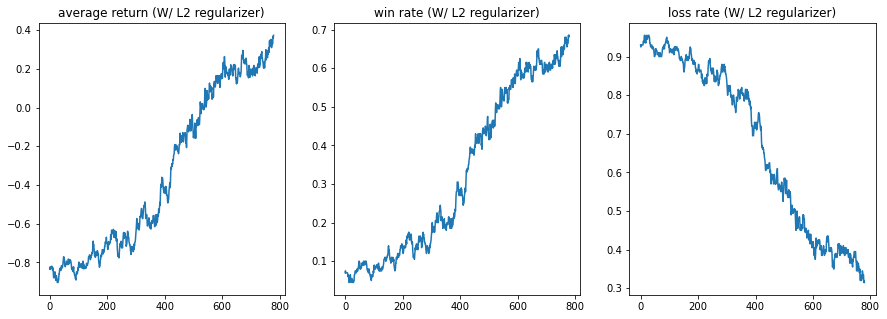

In [507]:
# plt.plot(returns)
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(moving_average(returns,20,1))
ax[0].set(title='average return (W/ L2 regularizer)')
# ax[1].plot(WR)
ax[1].plot(moving_average(WR,20,1))
ax[1].set(title='win rate (W/ L2 regularizer)')
ax[2].plot(moving_average(LR,20,1))
# ax[2].plot(LR)
ax[2].set(title='loss rate (W/ L2 regularizer)')

<BarContainer object of 4 artists>

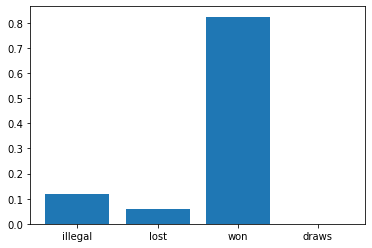

In [479]:
plt.bar(['illegal','lost','won','draws'],utils.state_dist(test_model,1000))

In [489]:
test_model.save_weights('./checkpoints/pos_pos_neg_1300epoch')

(0.31, 0.03, 0.66, 0.0)


<BarContainer object of 9 artists>

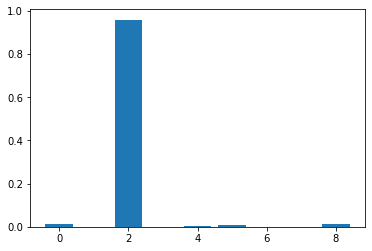

In [533]:
print(utils.state_dist(test_model,100))
plt.bar(list(range(9)),tf.squeeze(model.policy(np.zeros((1,18)))))

In [487]:
utils.gen_episode(test_model)

[((2, 1),
  array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]])),
 ((2, 0),
  array([[ 0,  0,  0],
         [ 0, -1,  0],
         [ 0,  1,  0]])),
 ((2, 2),
  array([[ 0,  0, -1],
         [ 0, -1,  0],
         [ 1,  1,  0]])),
 array([[ 0,  0, -1],
        [-1, -1,  0],
        [ 1,  1,  1]])]

In [598]:
dt = tf.constant(
    [[[0., np.e],
      [1., 0.]],
     
     [[np.e, 0.],
      [np.e, np.e]]])

print(tf.nn.softmax(dt))

st = tf.sparse.from_dense(dt)
res = tf.sparse.softmax(st)
res.indices
res.values
res.dense_shape
tf.sparse.to_dense(res)

tf.Tensor(
[[[0.06190317 0.9380968 ]
  [0.7310586  0.26894143]]

 [[0.9380968  0.06190317]
  [0.5        0.5       ]]], shape=(2, 2, 2), dtype=float32)


<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0. , 1. ],
        [1. , 0. ]],

       [[1. , 0. ],
        [0.5, 0.5]]], dtype=float32)>